#**Salesforce/blip-image-captioning-base**
– BLIP’s base model (~400 MB). Produces 1–2 sentence captions on CPU.



In [ ]:
!pip install -q transformers torch torchvision pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.2 MB/s eta 0:00:00


In [ ]:
# ──────────────── Imports ────────────────
import torch
from PIL import Image
import requests
import pandas as pd
from transformers import BlipProcessor, BlipForConditionalGeneration

# ──────────────── Device Setup ────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"

# ──────────────── Load BLIP Model & Processor ────────────────
print("Loading BLIP...")
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# ──────────────── Helper Functions ────────────────
def load_image(source: str) -> Image.Image:
    """
    Load an image from a URL or local file path and return a PIL Image (RGB).
    """
    if source.startswith("http"):
        return Image.open(requests.get(source, stream=True).raw).convert("RGB")
    else:
        return Image.open(source).convert("RGB")

def run_blip(image: Image.Image, prompt: str = None) -> str:
    """
    Run the BLIP (base) model. If a prompt is provided, it will be used for prompted captioning.
    After generation, any occurrence of the prompt text is removed from the returned caption.
    """
    if prompt:
        inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device)
    else:
        inputs = blip_processor(image, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs)
    caption = blip_processor.decode(out[0], skip_special_tokens=True)

    # Remove the prompt text from the generated caption if present
    if prompt:
        caption = caption.replace(prompt, "").strip()
    return caption

# ──────────────── Benchmark for BLIP Only ────────────────
def benchmark_blip(image_source: str, prompts: list) -> pd.DataFrame:
    """
    For a given image (URL or local path) and a list of prompts, run each prompt through
    BLIP and record the captions (with prompt text removed) in a pandas DataFrame.
    """
    image = load_image(image_source)
    records = []

    for prompt in prompts:
        record = {
            "Prompt": prompt if prompt is not None else "(no prompt)",
            "BLIP_Caption": run_blip(image, prompt),
        }
        records.append(record)

    return pd.DataFrame(records)

# ──────────────── Example Usage ────────────────
if __name__ == "__main__":
    image_url = "test5.png"
    prompts = [
        None,
        "Describe the scene.",
        "what the man is doing?",
        "What objects are in the image?"
    ]

    df = benchmark_blip(image_url, prompts)
    print(df.to_markdown(index=False))


Loading BLIP...
| Prompt                         | BLIP_Caption                                                    |
|:-------------------------------|:----------------------------------------------------------------|
| (no prompt)                    | a man in a suit and boxing gloves                               |
| Describe the scene.            | describe the scene.s are the most common characters in the film |
| what the man is doing?         |                                                                 |
| What objects are in the image? | what objects are in the image?                                  |


#**blip-image-captioning-large**
– BLIP large (~1.2 GB). Generates 1–3 sentence captions; needs ~6 GB VRAM or ~3–4 GB RAM on CPU.

In [ ]:
# ───────────── Install Dependencies ─────────────
!pip install -q transformers torch torchvision pillow pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.5 MB/s eta 0:00:00


In [ ]:

# ───────────── Imports ─────────────
import torch
from PIL import Image
import pandas as pd
from transformers import BlipProcessor, BlipForConditionalGeneration

# ───────────── Device Setup ─────────────
device = "cuda" if torch.cuda.is_available() else "cpu"

# ───────────── Load BLIP-Large Model & Processor ─────────────
print("Loading BLIP-Large...")
processor_large = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model_large     = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to(device)

# ───────────── Helper: Generate Captions ─────────────

Loading BLIP-Large...


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [ ]:


def generate_blip_large_caption(image_path: str, prompt: str = None, max_new_tokens: int = 50) -> str:
    """
    If prompt is None, do unconditional caption. Otherwise feed prompt as prefix.
    """
    img = Image.open(image_path).convert("RGB")
    if prompt is None:
        inputs = processor_large(images=img, return_tensors="pt").to(device)
    else:
        inputs = processor_large(images=img, text=prompt, return_tensors="pt").to(device)
    output_ids = model_large.generate(**inputs, max_new_tokens=max_new_tokens, num_beams=1)
    raw = processor_large.decode(output_ids[0], skip_special_tokens=True).strip()
    # Strip prompt if model echoed it verbatim
    if prompt and raw.lower().startswith(prompt.lower()):
        return raw[len(prompt):].strip()
    return raw

# ───────────── Example Usage: Captions for Different Prompts ─────────────
image_path = "test5.png"
prompts = [
    {"label": "(no prompt)",               "query": None},
    {"label": "Describe the scene.",       "query": "Describe the scene."},
    {"label": "What is the dog doing?",     "query": "What is the dog doing?"},
    {"label": "What objects are in the image?", "query": "What objects are in the image?"}
]

records = []
for entry in prompts:
    label = entry["label"]
    query = entry["query"]
    caption = generate_blip_large_caption(image_path, prompt=query, max_new_tokens=60)
    records.append({"Prompt": label, "BLIP-Large_Caption": caption})

df_large = pd.DataFrame(records)
pd.set_option('display.max_colwidth', None)  # ensure full captions are visible

# ───────────── Display Results as Markdown Table ─────────────
print("Salesforce/blip-image-captioning-large")
print("– BLIP large model (~1.2 GB). Generates 1–3 sentence captions; GPU recommended.\n")
print(df_large.to_markdown(index=False))


Salesforce/blip-image-captioning-large
– BLIP large model (~1.2 GB). Generates 1–3 sentence captions; GPU recommended.

| Prompt                         | BLIP-Large_Caption                                            |
|:-------------------------------|:--------------------------------------------------------------|
| (no prompt)                    | a close up of a man in a suit with a boxing glove on his head |
| Describe the scene.            | a man in a suit with a boxing glove on his head               |
| What is the dog doing?         |                                                               |
| What objects are in the image? |                                                               |


#**vit-gpt2-image-captioning**
nlpconnect/vit-gpt2-image-captioning
– ViT → GPT-2 (~370 MB). Also CPU-friendly; prompts via the VisionEncoderDecoder “decoder_input_ids” trick.

In [ ]:
!pip install transformers torch pillow pandas requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from transformers import (
    VisionEncoderDecoderModel,
    ViTFeatureExtractor,
    GPT2Tokenizer
)
from PIL import Image
import torch
import pandas as pd

# ───────── Device Setup ─────────
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ───────── Load Model & Preprocessors ─────────
model_name = "nlpconnect/vit-gpt2-image-captioning"
model = VisionEncoderDecoderModel.from_pretrained(model_name).to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# (Make sure GPT-2 has a pad token defined; if not, set it equal to eos_token_id)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id


Using device: cuda


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:

# ───────── Helper to Preprocess Image ─────────
def prepare_image(image_path: str) -> torch.Tensor:
    """
    1) Open PIL image, convert to RGB.
    2) Run through ViTFeatureExtractor: returns pixel_values tensors.
    3) Move to the correct device.
    """
    img = Image.open(image_path).convert("RGB")
    encoded = feature_extractor(img, return_tensors="pt")
    return encoded["pixel_values"].to(device)  # shape: (1, 3, H, W)

# ───────── Unconditional Generation (no prompt) ─────────
def generate_unconditional(image_path: str, max_length: int = 50) -> str:
    """
    Generate a caption with NO text prompt (purely from image).
    We set num_beams=1 to avoid the missing '_reorder_cache' error.
    """
    pixel_values = prepare_image(image_path)
    output_ids = model.generate(
        pixel_values=pixel_values,
        max_length=max_length,
        num_beams=1,             # <— must be 1 to avoid beam‐search reorder cache
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )
    text = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
    return text

# ───────── Generate with a Text Prefix (“Prompt”) ─────────
def generate_with_prompt(image_path: str, prompt_text: str, max_new_tokens: int = 50) -> str:
    """
    1) Preprocess image → pixel_values.
    2) Tokenize prompt_text → decoder_input_ids.
    3) Call model.generate(pixel_values=…, decoder_input_ids=…, num_beams=1).
    4) Decode and strip away the prompt portion.
    """
    pixel_values = prepare_image(image_path)
    tokenized = tokenizer(
        prompt_text,
        return_tensors="pt",
        add_special_tokens=False
    )
    decoder_input_ids = tokenized["input_ids"].to(device)
    output_ids = model.generate(
        pixel_values=pixel_values,
        decoder_input_ids=decoder_input_ids,
        max_new_tokens=max_new_tokens,
        num_beams=1,             # <— set to 1 (greedy) instead of 4
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )
    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
    # If GPT2 literally repeated our prompt_text at the front, strip it off:
    if full_text.lower().startswith(prompt_text.lower()):
        return full_text[len(prompt_text) :].strip()
    return full_text

# ─────────── Example: Print a Markdown Table ───────────
if __name__ == "__main__":
    image_path = "test5.png"  # ← Replace with your actual file
    prompts = [
        None,
        "Describe the scene.",
        "What is the man doing?",
        "What objects are in the image?"
    ]
    records = []
    for p in prompts:
        if p is None:
            cap = generate_unconditional(image_path, max_length=50)
            label = "(no prompt)"
        else:
            cap = generate_with_prompt(image_path, p, max_new_tokens=50)
            label = p
        records.append({
            "Prompt": label,
            "VIT-GPT2_Caption": cap
        })

    df = pd.DataFrame(records)
    print(df.to_markdown(index=False))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


| Prompt                         | VIT-GPT2_Caption                   |
|:-------------------------------|:-----------------------------------|
| (no prompt)                    | a man in a red shirt and a red tie |
| Describe the scene.            | a man in a suit and tie            |
| What is the man doing?         |                                    |
| What objects are in the image? |                                    |


#**Open AI**

by far the best preformance !

right now set to "gpt-4o-mini" posiible to change it to other models






In [1]:
# ───────────── Install Dependencies ─────────────
!pip install -q openai pandas

In [7]:
# ───────────── Imports & API Key Setup ─────────────
import openai
import pandas as pd
import base64 # Import base64 for image encoding
import os # Import os to demonstrate environment variable method

# Replace with your actual OpenAI API key
# It's better practice to load API keys from environment variables
# Ensure the OPENAI_API_KEY environment variable is set before running this.
# If you must hardcode for this example, keep it here:

## do not pubild this key !! @@@@
api_key_value = "sk-#@#4t0QqR0Mp0LK9lSBEez9xsIyVc8RCqQHUJZrNVluFaT3BlbkFJefjrEfoWGGGOhxVSsZkHDI2bQWi6IluZN_uHPnlCMA"

# Create an OpenAI client instance (new in v1.0.0+)
# Pass the API key directly to the constructor
# Alternatively, if using environment variables, you can remove the api_key=... part
client = openai.OpenAI(api_key=api_key_value)


# ───────────── Load Image Bytes and Encode ─────────────
image_path = "test4.png"
with open(image_path, "rb") as img_file:
    image_bytes = img_file.read()

# Encode the image bytes to base64 for inclusion in the API request
base64_image = base64.b64encode(image_bytes).decode("utf-8")


# ───────────── Define Prompts ─────────────
prompt_entries = [
   # {"label": "(no prompt)", "query": "Describe the image."}
    #{"label": "Describe the scene.", "query": "Describe the scene."},
    #{"label": "What is the man doing?", "query": "What is the man doing?"}
    {"label": "What objects are in the image?", "query": "What objects are in the image?"}
]

# ───────────── Send Requests & Collect Responses ─────────────
records = []
for entry in prompt_entries:
    try:
        # Use the new client.chat.completions.create syntax
        response = client.chat.completions.create(
            model="gpt-4o-mini",  # or another multimodal-capable model
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": entry["query"]},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{base64_image}"
                            },
                        },
                    ],
                }
            ],
        )
        # Access the content from the new response object structure
        caption = response.choices[0].message.content.strip()
        records.append({"Prompt": entry["label"], "OpenAI_Caption": caption})
    except Exception as e:
        # Handle potential API errors more gracefully
        print(f"Error processing prompt '{entry['query']}': {e}")
        records.append({"Prompt": entry["label"], "OpenAI_Caption": f"Error: {e}"})


# ───────────── Display as Markdown Table ─────────────
df = pd.DataFrame(records)
print(df.to_markdown(index=False))

| Prompt                         | OpenAI_Caption                                                                                                                                                                                                                                                                               |
|:-------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| What objects are in the image? | The image features a man in a green cardigan and a doctor in a white coat. The doctor is holding a prescription pad or a document and the patient is holding a medication bottle. The background suggests a medical office setting with shelves and some items that are not clearly visible. |


#**YOLO V8**

In [8]:
# ───────────── Install Dependencies ─────────────
!pip install -q ultralytics pandas pillow

# ───────────── Imports & Model Setup ─────────────
from ultralytics import YOLO
import pandas as pd
from PIL import Image
import numpy as np

from PIL import Image, ImageDraw, ImageFont # Import ImageFont
import matplotlib.pyplot as plt
import numpy as np
model = YOLO("yolov8x.pt")  # XL model, ~750 M

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 739.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyt

plot original photo with boxes


image 1/1 /content/test1.png: 320x640 1 dog, 2743.9ms
Speed: 3.3ms preprocess, 2743.9ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)
Could not load default font, text drawing might be basic.


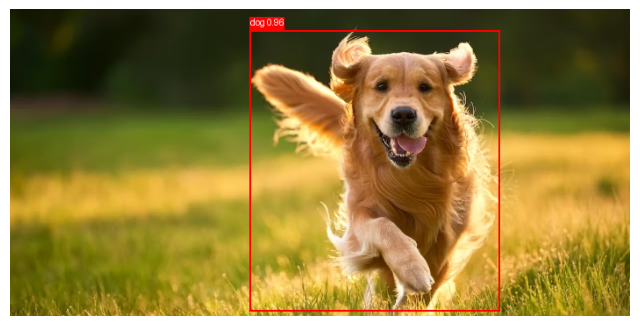

In [18]:
from ultralytics import YOLO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
# ───────────── Helper: Detect and Draw Boxes ─────────────
def show_image_with_boxes(image_path: str):
    """
    Runs YOLOv8x on the image, draws bounding boxes on the original,
    and displays it inline.
    """
    # 1) Load the image as a PIL Image
    img = Image.open(image_path).convert("RGB")

    # 2) Run YOLOv8x inference
    # Ensure 'model' is defined in the global scope or passed into the function
    # For this context, assuming 'model = YOLO("yolov8x.pt")' is run previously
    results = model(image_path)[0]  # only one image

    # 3) Create a drawing context and load a default font
    draw = ImageDraw.Draw(img)
    try:
        # Attempt to load a default font, handling potential exceptions
        font = ImageFont.load_default()
    except Exception:
        # Fallback if load_default fails or is not available
        print("Could not load default font, text drawing might be basic.")
        font = None # Or try loading a system font if necessary

    # 4) If there are detections, overlay them
    if hasattr(results, "boxes") and len(results.boxes) > 0:
        for box in results.boxes:
            # box.xyxy: tensor [[x1, y1, x2, y2]]
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().tolist()
            # Confidence and label
            conf = float(box.conf[0].cpu().numpy())
            cls_id = int(box.cls[0].cpu().numpy())
            label = model.names[cls_id]
            # Draw rectangle
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

            # Draw text background and label
            text = f"{label} {conf:.2f}"

            # --- FIX: Use textbbox instead of textsize ---
            if font:
                 # textbbox returns (left, top, right, bottom)
                bbox = draw.textbbox((x1, y1), text, font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
                # Draw background rectangle for text
                draw.rectangle([x1, y1 - text_height, x1 + text_width, y1], fill="red")
                 # Draw text
                draw.text((x1, y1 - text_height), text, fill="white", font=font)
            else:
                 # Fallback if font loading failed - draw text without background
                 # and potentially without size calculation if textlength is also unavailable
                 try:
                     # Use textlength as an alternative way to get width
                     text_width = draw.textlength(text)
                     # Approximate height (may need adjustment based on font size)
                     approx_text_height = 15 # Example approximation
                     draw.rectangle([x1, y1 - approx_text_height, x1 + text_width, y1], fill="red")
                     draw.text((x1, y1 - approx_text_height), text, fill="white")
                 except AttributeError:
                      # If textlength is also not available (older Pillow or custom build)
                      # Just draw the text directly at the top-left of the box
                      print(f"Warning: Could not calculate text size for '{text}'. Drawing text without background.")
                      draw.text((x1, y1), text, fill="white")
            # ---------------------------------------------

    # 5) Display the resulting image
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show() # Ensure the plot is displayed

# ───────────── Example Usage ─────────────
image_path = "test1.png"  # Replace with your image file
show_image_with_boxes(image_path)

print coordinate

In [20]:
# ───────────── Helper: Run YOLOv8x and Return Bounding Boxes ─────────────
def yolo8x_detect_boxes(image_path: str) -> pd.DataFrame:
    """
    Runs YOLOv8x on the given image and returns a DataFrame with:
      - x1, y1, x2, y2 (pixel coords)
      - confidence (float)
      - class_id (int)
      - label (string)
    """
    # 1) Run inference; YOLO will handle loading the image internally
    results = model(image_path)[0]  # index 0 for a single image

    # 2) If no detections, return empty DataFrame
    if not hasattr(results, "boxes") or len(results.boxes) == 0:
        return pd.DataFrame(columns=["x1", "y1", "x2", "y2", "confidence", "class_id", "label"])

    # 3) Extract each box
    data = []
    for box in results.boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().tolist()
        conf   = float(box.conf[0].cpu().numpy())
        cls_id = int(box.cls[0].cpu().numpy())
        label  = model.names[cls_id]
        data.append({
            "x1": x1,
            "y1": y1,
            "x2": x2,
            "y2": y2,
            "confidence": conf,
            "class_id": cls_id,
            "label": label
        })

    return pd.DataFrame(data)

# ───────────── Example Usage ─────────────
if __name__ == "__main__":
    image_path = "test3.png"  # replace with your file
    df_boxes = yolo8x_detect_boxes(image_path)
    print(df_boxes)


image 1/1 /content/test3.png: 384x640 1 person, 3 bottles, 2825.8ms
Speed: 4.2ms preprocess, 2825.8ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)
           x1          y1          x2          y2  confidence  class_id  \
0  140.088913  157.413834  368.686615  293.726410    0.745017         0   
1  366.360016   31.463484  398.689087   94.125687    0.329841        39   
2  295.671997   26.508411  340.226288   71.365585    0.284200        39   
3   88.172905   44.565601  131.298935  111.045158    0.283949        39   

    label  
0  person  
1  bottle  
2  bottle  
3  bottle  
